In [1]:
#in this one we check the strange (but not result-effecting) normalization problem....
#and downsample points
import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
#from datetime import datetime
from sklearn.decomposition import TruncatedSVD

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.experimentclasses.EthanolAngles import EthanolAngles
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_cosines
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell



from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle



#set parameters

#set parameters
n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
#lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 1. #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
cores = 3 #number of cores for parallel processing
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)

#these are just for loading... probably not necessary
nreps = 5
lambda_max = 1

folder = workingdirectory + '/Figures/ethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)


new_MN = True
new_grad = True
savename = 'ethanol_020521'
savefolder = 'ethanol'
loadfolder = 'ethanol'
loadname = 'ethanol_020521'
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

new_MN = True
new_grad = True
if new_MN == True:
    experiment = EthanolAngles(dim,  ii, jj,cores,atoms4)
    projector  = np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50_components.npy')
    experiment.M = experiment.load_data(workingdirectory = data_wd)  # if noise == False then noise parameters are overriden
    experiment.Mpca = RiemannianManifold(np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50.npy'), dim)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
natoms = 9
tol = 1e-14

atoms4,p = get_all_atoms_4(natoms)

subset = np.asarray([74, 176, 746, 665])
atoms4 = atoms4[subset]
p = 4

experiment.p = p
experiment.atoms4 = atoms4
#experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.folder = folder

replicates = {}
selected_points_save = np.zeros((nreps,nsel))

print('pre-gradient acquisition')
print(datetime.datetime.now())


/Users/samsonkoelle/manifoldflasso_jmlr
pre-gradient acquisition
2021-02-16 21:22:46.949955


In [2]:
def get_cos_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                #if ind[j] != k:
                coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    
    return (coses)


def get_incoherent_dictionary_include(dg_M, thresh, include):
    
    incoherent_indices = include

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, include)#**2
    print(coses.shape)
    cos_mean = coses.mean(axis = 0)
    keepers = np.where(np.abs(cos_mean).max(axis = 0) < thresh)[0]
    
    for i in range(dg_M.shape[2]):
        #print(i)
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        #coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])#**2
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        keepers = keepers[np.where(np.abs(np.mean(coses, axis = 0)) < thresh)[1]]
        #print(keepers)
        if len(keepers) == 0:
            print(i)
            break
            
    return(np.asarray(incoherent_indices, dtype = int))


def get_incoherent_dictionary_abscos_include(dg_M, thresh, include):
    
    incoherent_indices = include

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    coses = np.abs(get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, include))#**2
    print(coses.shape)
    cos_mean = coses.mean(axis = 0)
    keepers = np.where(np.abs(cos_mean).max(axis = 0) < thresh)[0]
    
    for i in range(dg_M.shape[2]):
        #print(i)
        id_add = np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        #coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])#**2
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        keepers = keepers[np.where(np.abs(np.mean(coses, axis = 0)) < thresh)[1]]
        #print(keepers)
        if len(keepers) == 0:
            print(i)
            break
            
    return(np.asarray(incoherent_indices, dtype = int))


def get_incoherent_dictionary_include_median(dg_M, thresh, include):
    
    incoherent_indices = include

    #dg_M_down = 
    keepers = np.asarray(list(range(dg_M.shape[2])))
    coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, include)#**2
    print(coses.shape)
    cos_mean = coses.mean(axis = 0)
    keepers = np.where(np.abs(cos_mean).max(axis = 0) < thresh)[0]
    
    for i in range(dg_M.shape[2]):
        #print(i)
        id_add = np.median(np.linalg.norm(dg_M[:,:,keepers], axis = tuple([1])), axis = 0).argmax()
        ind_add = keepers[id_add]
        incoherent_indices = np.append(incoherent_indices, ind_add)
        
        #ic_ind= np.linalg.norm(dg_M[:,:,keepers], axis = tuple([0,1])).argmax()
        #coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])[:,0,:]
        coses = get_cos_full_ind(np.swapaxes(dg_M[:,:,keepers],1,2)*n, [id_add])#**2
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        #keepers = keepers[np.where(np.mean(np.abs(coses), axis = 0) < thresh)[0]]
        keepers = keepers[np.where(np.abs(np.mean(coses, axis = 0)) < thresh)[1]]
        #print(keepers)
        if len(keepers) == 0:
            print(i)
            break
            
    return(np.asarray(incoherent_indices, dtype = int))

def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

def get_kappa_s(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    kappa_i = np.max(kappa_ij, axis = 1) / np.min(kappa_ij, axis = 1)
    kappa = np.max(kappa_i)    
    return(kappa)

def get_coses_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

def get_mu_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses.max())

def get_min_min(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    min_min = np.min(kappa_ij)
    return(min_min)

def get_gamma_max(dg_M):
    output = np.sum(np.sum(dg_M**2, axis = 1), axis = 0).max()
    return(output)

# def get_cosines(self, dg):
def get_cosines_full(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    coses = np.zeros((n, p, p))
    for i in range(n):
        #print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

# def get_cosines(self, dg):
def get_cosines2(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)


def get_grads2(experiment, Mpca, Mangles, N, selected_points,svd):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    
    n = len(selected_points)
    df_M2 = df_M / ((1/n)*np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5))
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([svd.transform( dg_w[j]).transpose() for j in range(len(selected_points))])
    #dg_w_pca = np.asarray([svd.transform( dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = np.einsum('n b d, n b p -> n d p', subM.tb.tangent_bases, dgw_norm) #experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)

In [3]:
svd = TruncatedSVD(n_components=50)
svd.fit(experiment.M.data)
data_pca = svd.transform(experiment.M.data)
experiment.Mpca.data = data_pca
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)

atoms4,p = get_all_atoms_4(natoms)
#trueandsel = [74,176,746,665]
experiment.atoms4 = atoms4#[trueandsel]
experiment.p = experiment.atoms4.shape[0]#4

In [4]:

sp = np.asarray([16215, 49362, 19182, 18592, 49137, 22288, 33303, 24487,  9851,
       18010, 14923,   473,  6696, 43574, 22256,  7345, 30498, 37444,
       23306, 18568, 20719, 16613,  5449, 31904, 27301, 21321, 14799,
       17370, 16440, 13743, 30374, 23904,  7957, 12666, 23161,  3581,
       20040, 37326, 25515, 31674, 37251, 34756, 19735,  7506,  6464,
        7428,  6885, 10172, 44424,  9368, 25457, 48791, 28860, 29399,
        6052, 27010, 13498, 42576, 38368, 40955, 11658, 24212, 19112,
        3600, 43800, 12911, 18539, 45952, 46354, 22614,  9057,  8499,
       41901, 15552, 18995,  8862, 46522, 11032,  6227, 36776, 36392,
       39113, 31308,  7973,  4861, 12368, 24716, 23979, 24628, 36028,
       38922, 27212, 40210,  8180, 32033, 11462, 27260,  7752,  9394,
       20369])
selected_points = sp

In [5]:
def get_grads3(experiment, Mpca, Mangles, N, selected_points,svd):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    
    n = len(selected_points)
    df_M2 = df_M / ((1/n)*np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5))
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([svd.transform( dg_w[j]).transpose() for j in range(len(selected_points))])
    #dg_w_pca = np.asarray([svd.transform( dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(np.swapaxes(dg_w_pca,1,2))
    dg_M = np.einsum('n b d, n b p -> n d p', subM.tb.tangent_bases, np.swapaxes(dgw_norm,1,2)) #experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)

In [6]:

sp = np.asarray([16215, 49362, 19182, 18592, 49137, 22288, 33303, 24487,  9851,
       18010, 14923,   473,  6696, 43574, 22256,  7345, 30498, 37444,
       23306, 18568, 20719, 16613,  5449, 31904, 27301, 21321, 14799,
       17370, 16440, 13743, 30374, 23904,  7957, 12666, 23161,  3581,
       20040, 37326, 25515, 31674, 37251, 34756, 19735,  7506,  6464,
        7428,  6885, 10172, 44424,  9368, 25457, 48791, 28860, 29399,
        6052, 27010, 13498, 42576, 38368, 40955, 11658, 24212, 19112,
        3600, 43800, 12911, 18539, 45952, 46354, 22614,  9057,  8499,
       41901, 15552, 18995,  8862, 46522, 11032,  6227, 36776, 36392,
       39113, 31308,  7973,  4861, 12368, 24716, 23979, 24628, 36028,
       38922, 27212, 40210,  8180, 32033, 11462, 27260,  7752,  9394,
       20369])
selected_points = sp

In [ ]:
def get_grads3(experiment, Mpca, Mangles, N, selected_points,svd):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    
    n = len(selected_points)
    df_M2 = df_M / ((1/n)*np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5))
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([svd.transform( dg_w[j]).transpose() for j in range(len(selected_points))])
    #dg_w_pca = np.asarray([svd.transform( dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(np.swapaxes(dg_w_pca,1,2))
    dg_M = np.einsum('n b d, n b p -> n d p', subM.tb.tangent_bases, np.swapaxes(dgw_norm,1,2)) #experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)

In [7]:
Mpca = experiment.Mpca
Mangles = experiment.M
N  = experiment.N
#selected_points
#svd

In [12]:
dg_M.shape

NameError: name 'dg_M' is not defined

In [8]:
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    
    n = len(selected_points)
    df_M2 = df_M / ((1/n)*np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5))
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([svd.transform( dg_w[j]).transpose() for j in range(len(selected_points))])
    #dg_w_pca = np.asarray([svd.transform( dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(np.swapaxes(dg_w_pca,1,2))
    dg_M = np.einsum('n b d, n b p -> n d p', subM.tb.tangent_bases, np.swapaxes(dgw_norm,1,2)) #experiment.project(subM.tb.tangent_bases, dgw_norm)
    #return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)

KeyboardInterrupt: 

In [9]:
np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0).shape

(3,)

In [10]:

#print(i)
#selected_points = np.random.choice(list(range(n)),nsel,replace = False)
#selected_points_save[i] = selected_points
selected_points = sp
i = 0
#experiment.atoms4 = atoms4[]
replicates[i] = Replicate()
replicates[i].nsel = nsel
replicates[i].selected_points = selected_points
replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points,svd)
#replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)
#replicates[i].df_M = replicates[i].tangent_bases
#replicates[i].dg_M = np.swapaxes(replicates[i].dg_M,1,2)

Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwar

In [13]:
#selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
r = 0 
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

p = replicates[0].dg_M.shape[2]
lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

#thresh = .8
#incoherent_indices = {}
#nreps = 5
results= {}
nreps = 1
#for r in range(nreps):
    #incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
replicates[r].dg_M = replicates[r].dg_M[:,:,:]
#p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
lambdas_start = [0.,ul]
results[r] = Replicate()
results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
converged 1087.6668967683386
0 543.8334483841693 probe
1 815.7501725762539 probe
2 951.7085346722963 probe
3 1019.6877157203174 probe
converged 1019.6877157203174
4 985.6981251963068 probe
converged 985.6981251963068
5 968.7033299343016 probe
converged 968.7033299343016
we did it [213 722]


In [14]:
include = np.asarray([74,176])
thresh = .2
incoherent_indices = {}
nreps = 1
for r in range(nreps):
    incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    #replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]

(100, 2, 756)
11


In [16]:
incoherent_indices

{0: array([ 74, 176, 584, 746, 635, 657, 665, 686, 659, 175, 100, 336,  41,
        523])}

In [15]:
dg_M_full = replicates[r].dg_M.copy()

In [17]:
nreps = 1
for r in range(nreps):
    #incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
converged 1063.3732181822004
0 531.6866090911002 probe
1 797.5299136366502 probe
converged 797.5299136366502
we did it [3 8]


In [18]:
incoherent_indices[0][[3,8]]

array([746, 659])

In [23]:
from einops import rearrange

In [43]:
nreps = 1
for r in range(nreps):
    #r = 0 
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis

#nreps = 5
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(zeros) == 2:
            sel_l[r] = l
            #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))

almost_sel = {}
sel = {}
for r in range(nreps):
    zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    almost_sel[r] = zeros

In [44]:
#pretty slow
a4, p = get_all_atoms_4(9)
g_mf_inc2 = np.zeros((1,2,50000))
for r in range(nreps):
    for o in range(2):
        print(o)
        g_mf_inc2[r,o] =  experiment.get_g_full_sub(experiment.M.data, a4[incoherent_indices[r][sel[r]][o]])

0
1


In [31]:
sel

{0: array([3, 8])}

Text(0.5, 0, '$\\phi_3$')

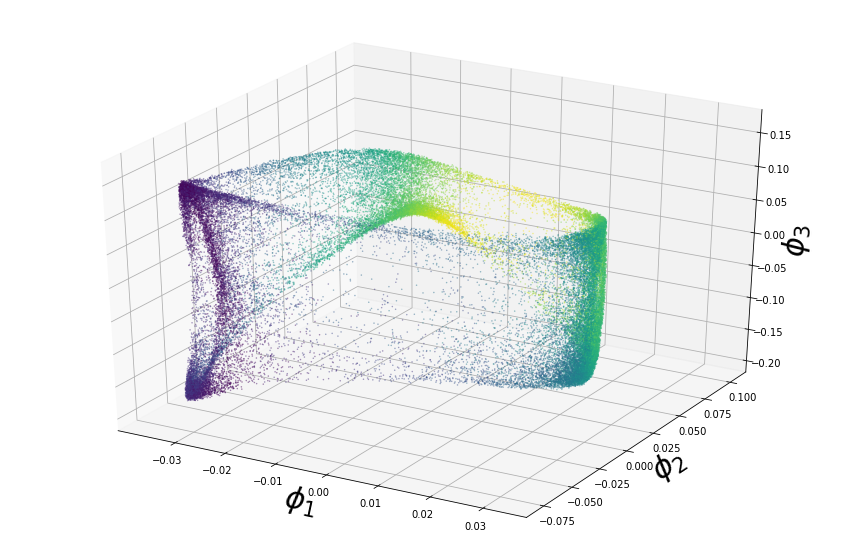

In [26]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_mf_inc2[0,0], alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)


Text(0.5, 0, '$\\phi_3$')

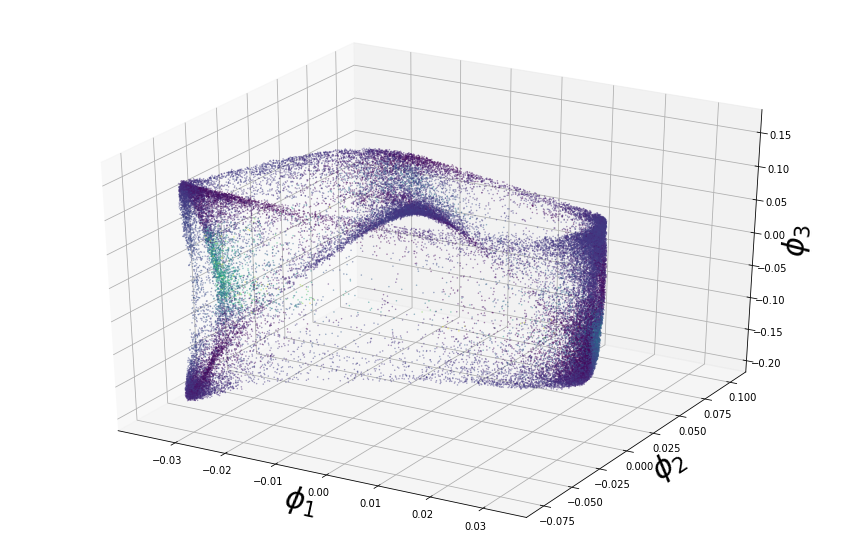

In [29]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_mf_inc2[0,1], alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)


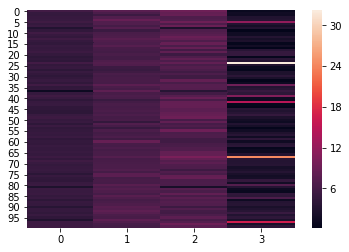

In [32]:
trueandsel = [74,176,746,659]
norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
%matplotlib inline
sns.heatmap(norms)

In [40]:
include = np.asarray([74,176])
thresh = .7
incoherent_indices = {}
nreps = 1
for r in range(nreps):
    incoherent_indices[r] = get_incoherent_dictionary_abscos_include(dg_M_full, thresh, include)
    #replicates[r].dg_M = replicates[r].dg_M[:,:,incoherent_indices[r]]

(100, 2, 756)
36


In [41]:
incoherent_indices

{0: array([ 74, 176, 423, 324, 330, 751, 750, 120, 268, 269, 292, 681, 701,
        306, 252, 300, 270, 311, 275, 274, 754, 753, 340,  11, 336, 339,
          4,  41,   7,   1,   8,  98, 338,  92, 523, 317, 527, 524, 128])}

In [42]:
nreps = 1
for r in range(nreps):
    #incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    replicates[r].dg_M = dg_M_full[:,:,incoherent_indices[r]]
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
converged 963.9353487146268
0 481.9676743573134 probe
1 722.9515115359701 probe
converged 722.9515115359701
we did it [2 3]


In [47]:
sel

{0: array([2, 3])}

In [48]:
incoherent_indices[0][[2,3]]

array([423, 324])

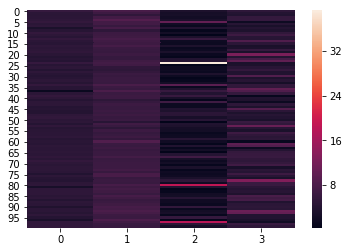

In [49]:
trueandsel = [74,176,423,324]
norms = np.linalg.norm(dg_M_full[:,:,np.asarray(trueandsel)], axis = 1)
%matplotlib inline
sns.heatmap(norms)

In [53]:
np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,:]), axis = tuple([0,2]))

array([693.84520797, 725.20990657, 963.93534871, 779.49673264,
       725.98496765, 694.29515369, 635.1449851 , 681.63757823,
       651.10952785, 566.38833346, 484.04964791, 506.70891903,
       449.81083394, 431.11659031, 459.5891131 , 360.33459697,
       392.68234784, 367.56281846, 374.8538784 , 371.40270645,
       349.51111451, 326.62248202,  96.9017128 ,  74.08604647,
        66.6093554 ,  73.26548525,  49.59577001,  56.17806392,
        53.25234117,  49.83746327,  58.70745289,  49.24676975,
        47.10103767,  44.40773755,  48.74197774,  48.33345587,
        41.28209679,  43.3385765 ,  36.29641108])

In [55]:
ptproj = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,:]), axis = tuple([2]))

(100, 39)


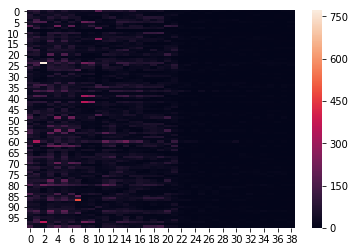

In [58]:
print(ptproj.shape)
sns.heatmap(ptproj)

Text(0.5, 0, '$\\phi_3$')

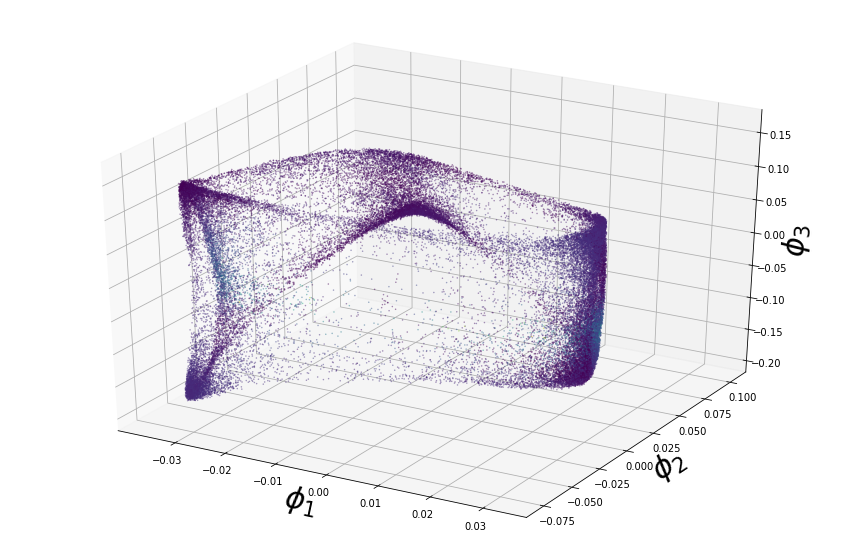

In [45]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_mf_inc2[0,0], alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)


Text(0.5, 0, '$\\phi_3$')

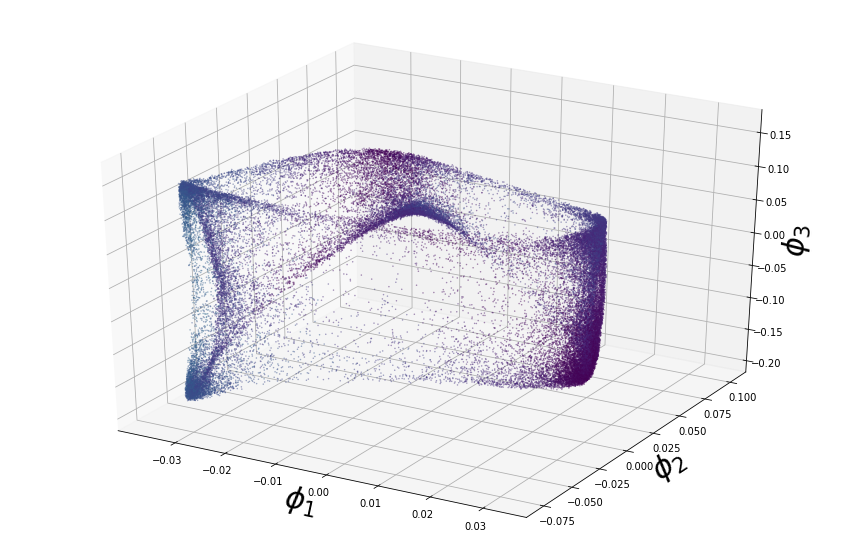

In [46]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_mf_inc2[0,1], alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)


In [60]:
norms = np.linalg.norm(replicates[0].dg_M[:,:,:], axis = 1)

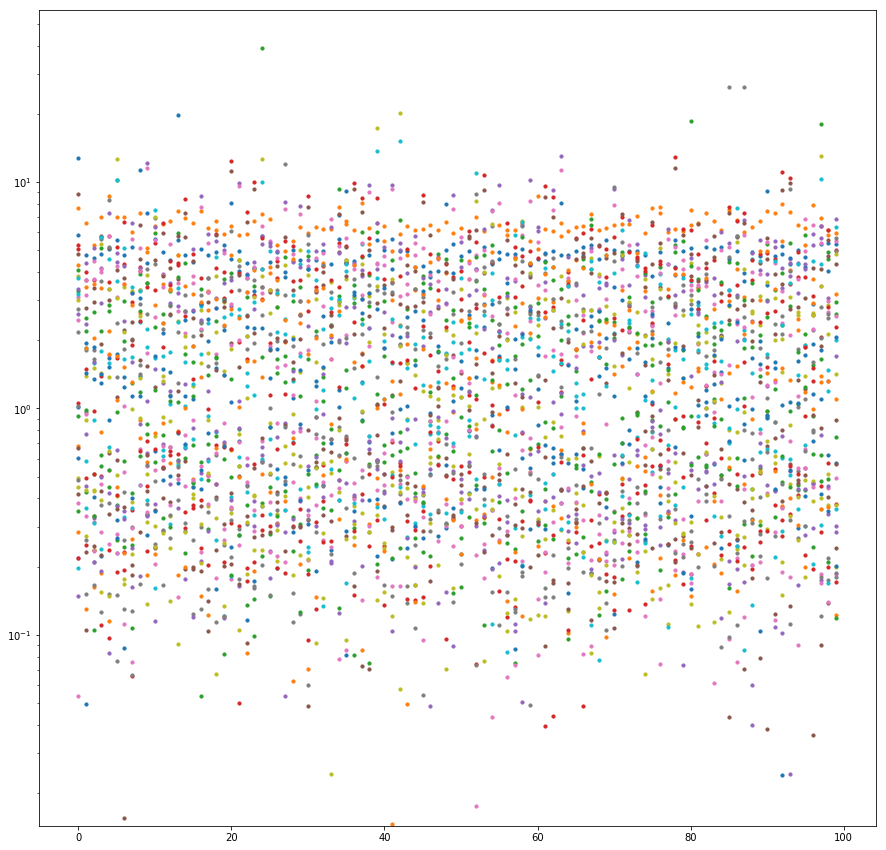

In [64]:
fig, ax = plt.subplots(1,1,figsize = (15,15))
for r in range(39):
    ax.scatter(list(range(100)), norms[:,r], s = 10)
plt.yscale('log')

In [76]:
np.asarray(np.where(norms > 15))[0]

array([13, 24, 39, 42, 42, 80, 85, 87, 97])

In [80]:
keepinds = np.setdiff1d(list(range(100)),np.where(norms > 15)[0])

In [87]:
dgw_down = replicates[0].dgw_norm[keepinds, :,:][:,incoherent_indices[0]]

In [89]:
dgw_down_norm = experiment.normalize(dgw_down)

In [92]:
np.linalg.norm(dgw_down_norm[:,0,:])

91.99999999999999

In [84]:
incoherent_indices[0]

array([ 74, 176, 423, 324, 330, 751, 750, 120, 268, 269, 292, 681, 701,
       306, 252, 300, 270, 311, 275, 274, 754, 753, 340,  11, 336, 339,
         4,  41,   7,   1,   8,  98, 338,  92, 523, 317, 527, 524, 128])

In [94]:
    dg_M_down = np.einsum('n b d, n b p -> n d p', experiment.subM.tb.tangent_bases[keepinds], np.swapaxes(dgw_down_norm,1,2)) #experiment.project(subM.tb.tangent_bases, dgw_norm)


AttributeError: 'EthanolAngles' object has no attribute 'subM'

In [98]:
    tangent_bases = experiment.Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(experiment.Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)


NameError: name 'Mpca' is not defined

In [103]:

#print(i)
#selected_points = np.random.choice(list(range(n)),nsel,replace = False)
#selected_points_save[i] = selected_points
selected_points = sp[keepinds]
i = 0
#experiment.atoms4 = atoms4[]
replicates[i] = Replicate()
replicates[i].nsel = nsel
replicates[i].selected_points = selected_points
replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points,svd)
#replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)
#replicates[i].df_M = replicates[i].tangent_bases
#replicates[i].dg_M = np.swapaxes(replicates[i].dg_M,1,2)

In [104]:
nreps = 1
for r in range(nreps):
    #incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    replicates[r].dg_M = replicates[i].dg_M[:,:,incoherent_indices[r]]
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
converged 693.9912192356717
0 346.99560961783584 probe
1 520.4934144267538 probe
converged 520.4934144267538
2 607.2423168312127 probe
converged 607.2423168312127
3 650.6167680334422 probe
converged 650.6167680334422
4 628.9295424323275 probe
converged 628.9295424323275
5 639.7731552328848 probe
converged 639.7731552328848
6 634.3513488326062 probe
converged 634.3513488326062
7 637.0622520327455 probe
converged 637.0622520327455
we did it [3 4]


In [105]:
incoherent_indices[0][[3,4]]

array([324, 330])

In [101]:
replicates[r].df_M.shape

(92, 2, 3)

In [102]:
 replicates[r].dg_M.shape

(100, 2, 39)

In [106]:
ptproj = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,:]), axis = tuple([2]))

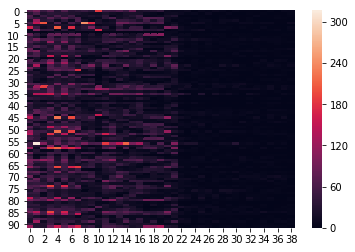

In [107]:
sns.heatmap(ptproj)

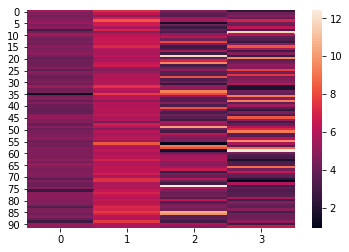

In [108]:
#trueandsel = [74,176,423,324]
norms = np.linalg.norm(replicates[r].dg_M[:,:,np.asarray([0,1,3,4])], axis = 1)
%matplotlib inline
sns.heatmap(norms)

array([[ 5.59439422,  7.37589609,  4.81272631,  2.48182713],
       [ 4.58607601,  6.32853718,  3.79559117,  4.20747049],
       [ 4.43949812,  5.08726143,  3.5067713 ,  4.86714957],
       [ 4.65220931,  6.75666734,  5.45276173,  3.98076164],
       [ 4.84850539,  8.37909771,  5.51255253,  6.98411706],
       [ 5.31881843,  6.75974503,  1.58112599,  4.25019752],
       [ 4.5960901 ,  6.77617006,  4.14625127,  4.07669406],
       [ 4.95682834,  5.80254107,  2.80452574,  6.26690662],
       [ 2.96906124,  7.04126545,  3.85478991,  3.18543971],
       [ 4.22048933,  4.92959806,  3.26486475, 11.55920593],
       [ 5.40345958,  6.19348004,  5.13108788,  6.04969875],
       [ 4.70888835,  6.31745129,  6.28421765,  3.75768406],
       [ 4.33594615,  6.48432686,  4.24046181,  3.4236169 ],
       [ 4.58542716,  6.6689206 ,  7.98943487,  2.57576192],
       [ 4.25811585,  6.36273507,  4.58758242,  4.81120084],
       [ 4.87697431,  7.16508412,  2.75524502,  8.31829466],
       [ 4.5966562 ,  6.

In [113]:
np.linalg.norm(ptproj, axis = 0)

array([612.84905587, 645.20631281, 484.09501068, 693.99121924,
       651.39013382, 622.75863254, 566.58337771, 525.89919995,
       381.432315  , 382.75285004, 396.71467926, 442.38749025,
       399.06340399, 357.87854964, 395.43004373, 305.58599075,
       339.52449098, 311.15953401, 319.78302719, 317.9632557 ,
       327.13063792, 304.074986  ,  87.29401703,  65.91733594,
        58.81067845,  64.58358485,  43.68582624,  49.52510663,
        48.16427453,  43.9409214 ,  53.22207667,  42.64619057,
        40.86073383,  38.78130131,  40.06282428,  41.47863003,
        36.99469497,  37.61081359,  31.72493246])

In [114]:
dg_M_supersub = replicates[r].dg_M[:,:,np.asarray([0,1,3,4])].copy()

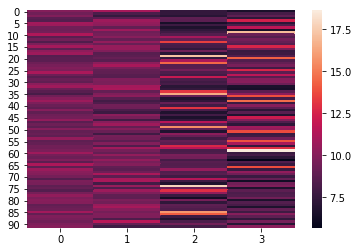

In [126]:
sns.heatmap(np.linalg.norm(replicates[0].dgw_norm, axis = 2)[:,[74,176,324,330]])

In [115]:
nreps = 1
for r in range(nreps):
    #incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    replicates[r].dg_M = dg_M_supersub
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
converged 693.9912192356718
0 346.9956096178359 probe
converged 346.9956096178359
1 520.4934144267538 probe
converged 520.4934144267538
2 607.2423168312127 probe
converged 607.2423168312127
3 650.6167680334422 probe
converged 650.6167680334422
4 628.9295424323275 probe
converged 628.9295424323275
5 639.7731552328848 probe
converged 639.7731552328848
6 634.3513488326062 probe
converged 634.3513488326062
7 637.0622520327455 probe
converged 637.0622520327455
we did it [2 3]


In [130]:
np.var(np.linalg.norm(replicates[0].dgw_norm, axis = 2)[:,[74,176,324,330]], axis =  0)

array([0.52906081, 0.89457835, 6.28958364, 5.63731735])

In [131]:
np.var(np.linalg.norm(replicates[0].dgw_norm, axis = 2)[:,[74,176,324,330]])

3.3572826955440895

In [129]:
np.mean(np.linalg.norm(replicates[0].dgw_norm, axis = 2)[:,[74,176,324,330]], axis =  0)

array([9.56404408, 9.54491601, 9.25799203, 9.29315246])

In [132]:
np.mean(np.linalg.norm(replicates[0].dgw_norm, axis = 2)[:,[74,176,324,330]])

9.415026144650684

In [138]:
highenough = np.asarray(np.where(np.linalg.norm(replicates[0].dgw_norm, axis = 2)[:,[74,176,324,330]] > 6)).transpose()

In [137]:
lowenough = np.asarray(np.where(np.linalg.norm(replicates[0].dgw_norm, axis = 2)[:,[74,176,324,330]] < 13)).transpose()

In [ ]:
Counter(highenough)

In [140]:
intersetingRows=[(highenough==irow).all(axis=1).any() for irow in lowenough]
goodness = lowenough[intersetingRows]

In [151]:
of92 = np.where(np.asarray(list(Counter(goodness[:,0]).values())) == 4)[0]

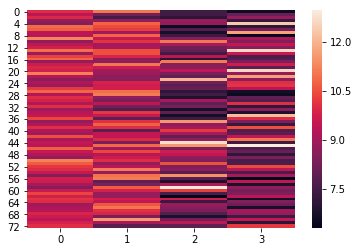

In [152]:
sns.heatmap(np.linalg.norm(replicates[0].dgw_norm[of92], axis = 2)[:,[74,176,324,330]])

In [154]:
replicates[0].dgw_norm[of92].shape

(73, 756, 50)

In [159]:
dgw_norm_of92 = experiment.normalize(replicates[0].dgw_norm[of92])

In [165]:
np.linalg.norm(dgw_norm_of92, axis = tuple([0,2]))

array([73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73

In [168]:
dg_M_of92 = np.einsum('n b d, n p b -> n d p', replicates[0].tangent_bases[of92], dgw_norm_of92) #experiment.project(subM.tb.tangent_bases, dgw_norm)
df_M_of92 = replicates[0].df_M[of92]

In [170]:
dg_M_of92.shape

(73, 2, 756)

In [171]:
nreps = 1
for r in range(nreps):
    #incoherent_indices[r] = get_incoherent_dictionary_include(replicates[r].dg_M, thresh, include)
    replicates[r].dg_M = dg_M_of92[:,:,[74,176,324,330]]
    replicates[r].df_M = df_M_of92
    p = np.asarray(incoherent_indices[r], dtype = int).shape[0]
    ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    results[r] = Replicate()
    results[r] = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate)


initializing lambda search
converged 534.3093801372294
0 267.1546900686147 probe
1 400.73203510292205 probe
converged 400.73203510292205
2 467.5207076200757 probe
converged 467.5207076200757
3 500.91504387865257 probe
converged 500.91504387865257
we did it [1 3]


In [ ]:
sns.heatmap(np.linalg.norm(replicates[0].dgw_norm, axis = 2)[:,[74,176,324,330]])

In [ ]:
def get_grads_thresh(experiment, Mpca, Mangles, N, selected_points,svd):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    
    n = len(selected_points)
    df_M2 = df_M / ((1/n)*np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5))
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([svd.transform( dg_w[j]).transpose() for j in range(len(selected_points))])
    #dg_w_pca = np.asarray([svd.transform( dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(np.swapaxes(dg_w_pca,1,2))
    dg_M = np.einsum('n b d, n b p -> n d p', subM.tb.tangent_bases, np.swapaxes(dgw_norm,1,2)) #experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)

In [ ]:
incoherent_indices[0][[2,3]]

In [172]:
g_330 =  experiment.get_g_full_sub(experiment.M.data, a4[330])

Text(0.5, 0, '$\\phi_3$')

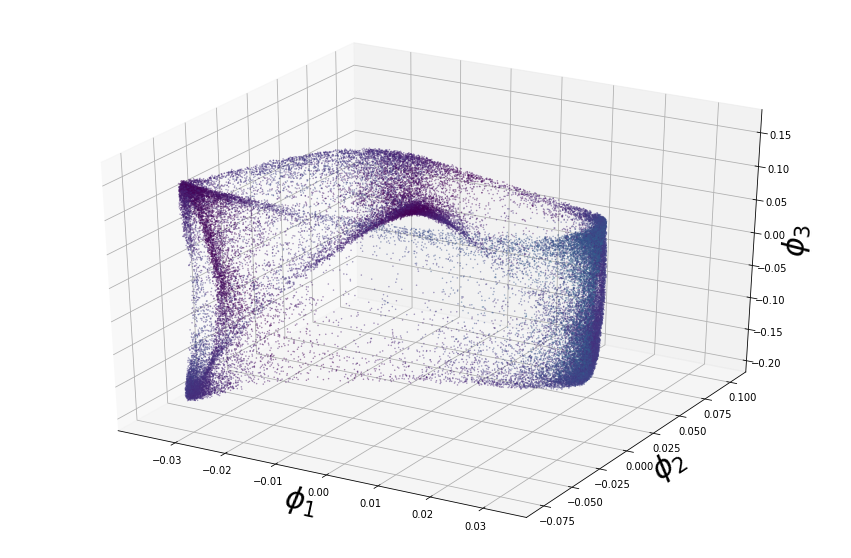

In [173]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_330, alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)


In [174]:
ptproj = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,:]), axis = tuple([2]))

In [177]:
np.linalg.norm(ptproj, axis = 0)

array([486.92643557, 513.26052973, 500.74152119, 534.30938014])

In [183]:
ptproj[:,3].argsort()

array([ 8, 34, 47, 56,  4, 71, 55, 37, 17, 61, 10, 59, 60, 44, 48, 68, 21,
       32, 30,  6, 23, 66, 24, 64, 25, 27, 50, 51, 69, 53, 65, 28,  0,  1,
       41, 12, 29, 49, 38, 18, 16, 31, 70, 58, 33, 36,  3, 54, 11, 40, 46,
       15, 57, 63, 67, 19, 39,  2,  5, 42, 22, 14, 13, 20, 43,  9, 26, 52,
       62, 72,  7, 45, 35])

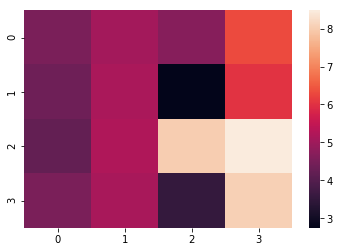

In [186]:
sns.heatmap(np.linalg.norm(replicates[r].dg_M[[72,  7, 45, 35],:,:], axis = 1))

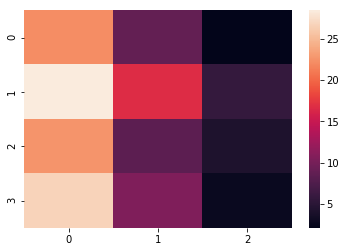

In [187]:
sns.heatmap(np.linalg.norm(replicates[r].df_M[[72,  7, 45, 35],:,:], axis = 1))

In [188]:
ptproj = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M[[72,  7, 45, 35]] , replicates[r].dg_M[[72,  7, 45, 35],:,:]), axis = tuple([2]))

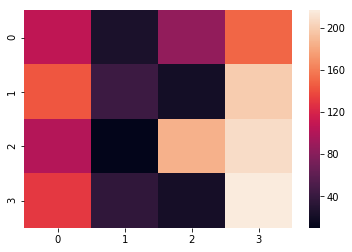

In [189]:
sns.heatmap(ptproj) #projections

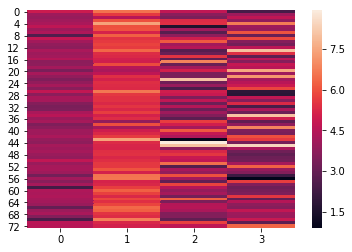

In [180]:
sns.heatmap(np.linalg.norm(replicates[0].dg_M, axis = 1))

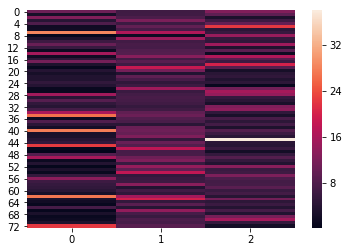

In [181]:

sns.heatmap(np.linalg.norm(replicates[0].df_M , axis = 1))